In [1]:
import pickle
import pandas as pd
from functions import feature_encoder #, target_encoder
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("../notebooks/LosingTime/users_data_cleaned.csv")
df.head()

,gender,age,signup_method,language,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,TARGET,year_account_created,month_account_created
0,MALE,38.0,facebook,english,google,untracked,Web,MacBook,Google Chrome,LoseTime,2011,5
1,FEMALE,56.0,basic,english,direct,untracked,Web,Laptop,Microsoft Edge,Booked,2010,9
2,FEMALE,42.0,facebook,english,direct,untracked,Web,MacBook,Firefox,Booked,2011,12
3,FEMALE,46.0,basic,english,other,untracked,Web,MacBook,Safari,Booked,2010,1
4,FEMALE,47.0,basic,english,direct,ads,Web,MacBook,Safari,Booked,2010,1


In [3]:
encoding_cols = df.select_dtypes('object').columns.drop('TARGET')
df = feature_encoder(df, encoding_cols)
#df = target_encoder(df, 'TARGET')

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['TARGET'] = label_encoder.fit_transform(df.TARGET)

In [4]:
df

,gender,age,signup_method,language,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,TARGET,year_account_created,month_account_created
0,1.0,38.0,1.0,1.0,3.0,4.0,2.0,3.0,1.0,1,2011,5
1,0.0,56.0,0.0,1.0,1.0,4.0,2.0,2.0,2.0,0,2010,9
2,0.0,42.0,1.0,1.0,1.0,4.0,2.0,3.0,0.0,0,2011,12
3,0.0,46.0,0.0,1.0,4.0,4.0,2.0,3.0,5.0,0,2010,1
4,0.0,47.0,0.0,1.0,1.0,0.0,2.0,3.0,5.0,0,2010,1
...,...,...,...,...,...,...,...,...,...,...,...,...
108385,0.0,24.0,0.0,1.0,1.0,4.0,3.0,5.0,5.0,1,2014,6
108386,0.0,34.0,0.0,1.0,1.0,0.0,2.0,3.0,1.0,0,2014,6
108387,0.0,36.0,0.0,1.0,3.0,0.0,2.0,3.0,5.0,0,2014,6
108388,0.0,23.0,0.0,1.0,3.0,0.0,2.0,2.0,2.0,0,2014,6


In [5]:
X, y = df.drop('TARGET', axis=1), df['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [6]:
xgb_params = {
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.6,
    'seed': 2018,
    'eval_metric': 'error',  # 'error' is used for binary classification instead of 'merror'
    'objective': 'binary:logistic',  # 'binary:logistic' for binary classification
    'max_depth': 4
}

xgb = XGBClassifier()
xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [7]:
from sklearn.metrics import classification_report

y_pred = xgb.predict(X_test)

class_report = classification_report(y_test, y_pred)

print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.67      0.65     11267
           1       0.62      0.59      0.61     10411

    accuracy                           0.63     21678
   macro avg       0.63      0.63      0.63     21678
weighted avg       0.63      0.63      0.63     21678



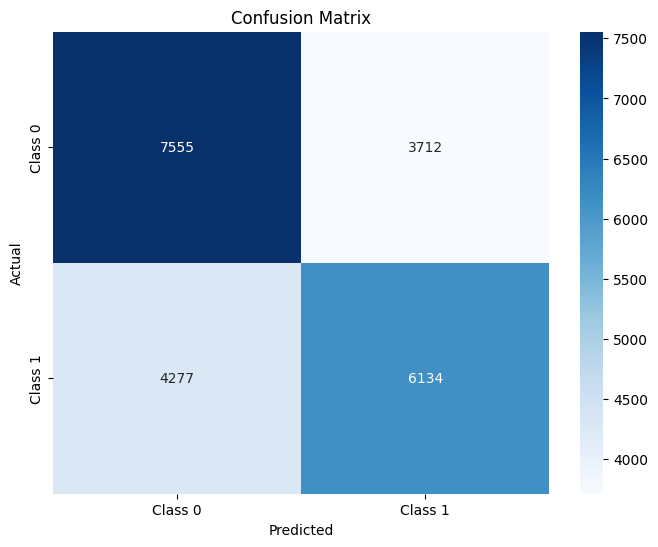

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = xgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


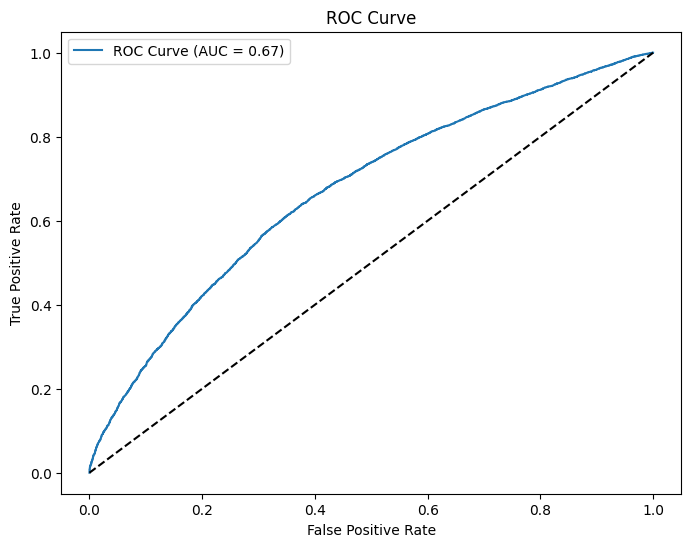

In [9]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_prob = xgb.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


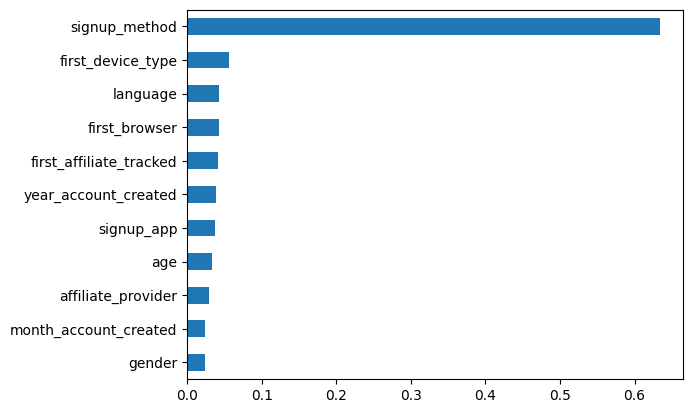

In [10]:
pd.Series(xgb.feature_importances_, index=X_train.columns).sort_values().plot(kind='barh');

In [11]:
X, y = df.drop('TARGET', axis=1), df['TARGET']
xgb = XGBClassifier()
xgb.fit(X, y)

pickle.dump(xgb, open("model.pkl", "wb"))